In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

C:\ANACONDA\envs\pytorch_dl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GoogLeNet(nn.Module):
    def __init__(self,in_channels=3,num_classes = 1000):
        super(GoogLeNet, self).__init__()
        self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size = 7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_block(64, 192, kernel_size = 3, stride = 1, padding = 1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        #ORDER in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

class Inception_block(nn.Module):
    def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
        super(Inception_block, self).__init__()

        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            conv_block(in_channels, red_3x3, kernel_size = 1),
            conv_block(red_3x3, out_3x3, kernel_size = 3, stride = 1, padding =1),
        )
        self.branch3 = nn.Sequential(
            conv_block(in_channels, red_5x5, kernel_size=1),
            conv_block(red_5x5, out_5x5, kernel_size=5, stride = 1, padding = 2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            conv_block(in_channels, out_1x1pool, kernel_size = 1),
        )

    def forward(self, x):
        # N x filters x 28 x 28
        #WE concatenate along the first dimension, essentially along the filters
        return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)


class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        #kwargs are keyword arguments
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))

In [21]:
#MNIST
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

In [22]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'],
 {'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9})

In [23]:
import torch.utils.data as data_utils

indices_train = torch.arange(1000)
indices_test = torch.arange(100)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(1000, 100)

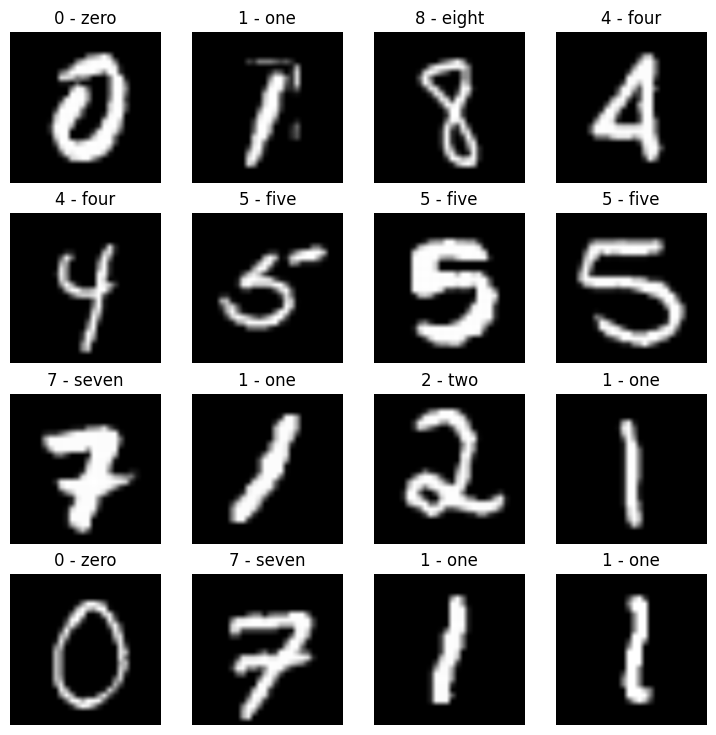

In [24]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [25]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [26]:
model_InceptionNET_0 = GoogLeNet(in_channels=1, num_classes=10).to(device)

In [27]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_InceptionNET_0.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [29]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [30]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [31]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=20

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.35739, Train acc: 14.04%


  5%|▌         | 1/20 [00:23<07:35, 23.96s/it]

Test Loss: 1057620.75000, Test acc: 11.63%
Epoch: 1 ----


 10%|█         | 2/20 [00:30<04:06, 13.71s/it]

Train Loss: 2.33568, Train acc: 24.22%
Test Loss: 1273.71765, Test acc: 11.63%
Epoch: 2 ----


 15%|█▌        | 3/20 [00:37<02:57, 10.43s/it]

Train Loss: 2.14115, Train acc: 27.38%
Test Loss: 5.85654, Test acc: 26.56%
Epoch: 3 ----


 20%|██        | 4/20 [00:43<02:22,  8.90s/it]

Train Loss: 1.68042, Train acc: 40.82%
Test Loss: 2.70893, Test acc: 33.51%
Epoch: 4 ----


 25%|██▌       | 5/20 [00:50<02:00,  8.06s/it]

Train Loss: 1.36623, Train acc: 51.17%
Test Loss: 3.11554, Test acc: 39.93%
Epoch: 5 ----


 30%|███       | 6/20 [00:56<01:45,  7.54s/it]

Train Loss: 1.12604, Train acc: 60.94%
Test Loss: 1.97702, Test acc: 56.25%
Epoch: 6 ----
Train Loss: 0.83324, Train acc: 71.39%


 35%|███▌      | 7/20 [01:05<01:42,  7.90s/it]

Test Loss: 0.76690, Test acc: 75.35%
Epoch: 7 ----


 40%|████      | 8/20 [01:11<01:29,  7.43s/it]

Train Loss: 0.65374, Train acc: 79.24%
Test Loss: 0.83663, Test acc: 68.49%
Epoch: 8 ----


 45%|████▌     | 9/20 [01:18<01:18,  7.11s/it]

Train Loss: 0.40438, Train acc: 87.58%
Test Loss: 0.29763, Test acc: 88.37%
Epoch: 9 ----


 50%|█████     | 10/20 [01:24<01:08,  6.90s/it]

Train Loss: 0.31574, Train acc: 89.75%
Test Loss: 0.52382, Test acc: 85.07%
Epoch: 10 ----


 55%|█████▌    | 11/20 [01:31<01:00,  6.77s/it]

Train Loss: 0.29198, Train acc: 89.90%
Test Loss: 0.64517, Test acc: 83.68%
Epoch: 11 ----


 60%|██████    | 12/20 [01:39<00:59,  7.39s/it]

Train Loss: 0.26136, Train acc: 91.56%
Test Loss: 0.60591, Test acc: 78.47%
Epoch: 12 ----


 65%|██████▌   | 13/20 [01:49<00:56,  8.12s/it]

Train Loss: 0.21907, Train acc: 93.26%
Test Loss: 0.26895, Test acc: 91.93%
Epoch: 13 ----


 70%|███████   | 14/20 [01:56<00:45,  7.65s/it]

Train Loss: 0.19184, Train acc: 93.89%
Test Loss: 0.51582, Test acc: 86.02%
Epoch: 14 ----


 75%|███████▌  | 15/20 [02:02<00:36,  7.31s/it]

Train Loss: 0.23914, Train acc: 92.83%
Test Loss: 0.27112, Test acc: 91.93%
Epoch: 15 ----


 80%|████████  | 16/20 [02:11<00:31,  7.79s/it]

Train Loss: 0.19651, Train acc: 93.40%
Test Loss: 0.33447, Test acc: 89.76%
Epoch: 16 ----


 85%|████████▌ | 17/20 [02:18<00:22,  7.43s/it]

Train Loss: 0.17487, Train acc: 93.44%
Test Loss: 0.30953, Test acc: 90.54%
Epoch: 17 ----


 90%|█████████ | 18/20 [02:24<00:14,  7.17s/it]

Train Loss: 0.12112, Train acc: 96.48%
Test Loss: 0.10657, Test acc: 96.27%
Epoch: 18 ----


 95%|█████████▌| 19/20 [02:31<00:06,  6.97s/it]

Train Loss: 0.07953, Train acc: 97.48%
Test Loss: 0.24183, Test acc: 93.49%
Epoch: 19 ----


100%|██████████| 20/20 [02:37<00:00,  7.89s/it]

Train Loss: 0.09034, Train acc: 97.40%
Test Loss: 0.36923, Test acc: 86.20%
Train time on cuda : 157.893 seconds


In [41]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [32]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "00_InceptionNET_MNISTpth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [34]:
#Saving the model
torch.save(obj=model_InceptionNET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\00_InceptionNET_MNISTpth


In [39]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_MNIST = GoogLeNet(in_channels=1, num_classes=10).to(device)
model_InceptionNET_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [42]:
#Get model results
model_InceptionNET_MNIST_results = eval_model(
    model=model_InceptionNET_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_MNIST_results

100%|██████████| 2/2 [00:00<00:00,  2.44it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 0.3692275285720825,
 'model_acc': 86.19791666666667}

In [47]:
#FashionMNIST
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

In [48]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [49]:
import torch.utils.data as data_utils

indices_train = torch.arange(1000)
indices_test = torch.arange(100)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(1000, 100)

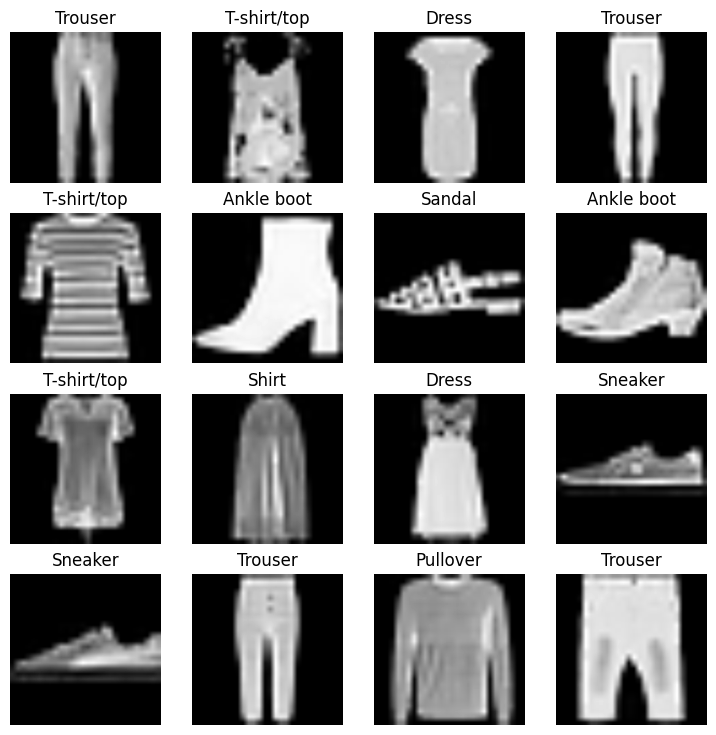

In [50]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [51]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [52]:
model_InceptionNET_1 = GoogLeNet(in_channels=1, num_classes=10).to(device)

In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_InceptionNET_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [54]:
#TRAINING AND TESTING

In [61]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=20

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_InceptionNET_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_InceptionNET_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 ----


  5%|▌         | 1/20 [00:07<02:17,  7.21s/it]

Train Loss: 0.57584, Train acc: 78.61%
Test Loss: 0.96899, Test acc: 68.75%
Epoch: 1 ----


 10%|█         | 2/20 [00:13<02:02,  6.81s/it]

Train Loss: 0.56877, Train acc: 79.02%
Test Loss: 0.82058, Test acc: 71.70%
Epoch: 2 ----


 15%|█▌        | 3/20 [00:22<02:12,  7.82s/it]

Train Loss: 0.53894, Train acc: 79.65%
Test Loss: 0.79210, Test acc: 75.43%
Epoch: 3 ----


 20%|██        | 4/20 [00:29<01:57,  7.34s/it]

Train Loss: 0.44568, Train acc: 84.41%
Test Loss: 0.69935, Test acc: 74.65%
Epoch: 4 ----


 25%|██▌       | 5/20 [00:38<01:59,  7.93s/it]

Train Loss: 0.43735, Train acc: 83.28%
Test Loss: 0.86712, Test acc: 70.92%
Epoch: 5 ----


 30%|███       | 6/20 [00:44<01:44,  7.49s/it]

Train Loss: 0.44642, Train acc: 83.44%
Test Loss: 0.91948, Test acc: 74.05%
Epoch: 6 ----


 35%|███▌      | 7/20 [00:53<01:43,  7.96s/it]

Train Loss: 0.38159, Train acc: 85.33%
Test Loss: 0.86714, Test acc: 69.88%
Epoch: 7 ----


 40%|████      | 8/20 [01:00<01:30,  7.50s/it]

Train Loss: 0.37529, Train acc: 86.72%
Test Loss: 0.65373, Test acc: 76.82%
Epoch: 8 ----


 45%|████▌     | 9/20 [01:06<01:19,  7.19s/it]

Train Loss: 0.34926, Train acc: 86.29%
Test Loss: 0.94248, Test acc: 75.26%
Epoch: 9 ----


 50%|█████     | 10/20 [01:15<01:16,  7.66s/it]

Train Loss: 0.42349, Train acc: 84.32%
Test Loss: 2.33511, Test acc: 58.25%
Epoch: 10 ----


 55%|█████▌    | 11/20 [01:25<01:13,  8.21s/it]

Train Loss: 0.43732, Train acc: 84.51%
Test Loss: 0.91212, Test acc: 70.31%
Epoch: 11 ----


 60%|██████    | 12/20 [01:31<01:01,  7.69s/it]

Train Loss: 0.36454, Train acc: 86.00%
Test Loss: 1.54795, Test acc: 68.58%
Epoch: 12 ----


 65%|██████▌   | 13/20 [01:41<00:58,  8.35s/it]

Train Loss: 0.34785, Train acc: 87.11%
Test Loss: 0.89058, Test acc: 74.65%
Epoch: 13 ----


 70%|███████   | 14/20 [01:50<00:51,  8.63s/it]

Train Loss: 0.32550, Train acc: 87.60%
Test Loss: 0.86286, Test acc: 78.39%
Epoch: 14 ----


 75%|███████▌  | 15/20 [02:00<00:44,  8.87s/it]

Train Loss: 0.29202, Train acc: 89.45%
Test Loss: 0.88201, Test acc: 76.39%
Epoch: 15 ----


 80%|████████  | 16/20 [02:16<00:44, 11.05s/it]

Train Loss: 0.25703, Train acc: 90.49%
Test Loss: 1.03195, Test acc: 74.48%
Epoch: 16 ----
Train Loss: 0.22355, Train acc: 92.01%


 85%|████████▌ | 17/20 [02:35<00:40, 13.35s/it]

Test Loss: 0.96674, Test acc: 72.66%
Epoch: 17 ----


 90%|█████████ | 18/20 [02:56<00:31, 15.86s/it]

Train Loss: 0.24184, Train acc: 91.02%
Test Loss: 1.03293, Test acc: 65.10%
Epoch: 18 ----
Train Loss: 0.23060, Train acc: 92.29%


 95%|█████████▌| 19/20 [03:15<00:16, 16.83s/it]

Test Loss: 0.99316, Test acc: 76.39%
Epoch: 19 ----


100%|██████████| 20/20 [03:27<00:00, 10.40s/it]

Train Loss: 0.27919, Train acc: 89.63%
Test Loss: 0.74283, Test acc: 80.90%
Train time on cuda : 207.945 seconds


In [62]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_InceptionNET_FashionMNISTpth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [63]:
#Saving the model
torch.save(obj=model_InceptionNET_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models\01_InceptionNET_FashionMNISTpth


In [65]:
#Loading the model
#Create a new instance of the model and update the parameters
model_InceptionNET_FashionMNIST = GoogLeNet(in_channels=1, num_classes=10).to(device)
model_InceptionNET_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [67]:
#Get model results
model_InceptionNET_FashionMNIST_results = eval_model(
    model=model_InceptionNET_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_InceptionNET_FashionMNIST_results

100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


{'model_name': 'GoogLeNet',
 'model_loss': 18.16619110107422,
 'model_acc': 9.027777777777779}